In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import gradio as gr
import numpy as np

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

#AYARLAR 

RAW_TRAIN_DIR = 'dataset/train'
RAW_VAL_DIR = 'dataset/val'
CROPPED_TRAIN_DIR = 'dataset_cropped/train'
CROPPED_VAL_DIR = 'dataset_cropped/val'

IMG_SIZE = (160, 160) 
BATCH_SIZE = 32 
def crop_faces_and_save(source_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    classes = os.listdir(source_dir)
    print(f"İşleniyor: {source_dir} -> {dest_dir}")
    
    total_processed = 0
    total_faces_found = 0
    
    for class_name in classes:
        if class_name.startswith('.'): continue 
        
        class_path = os.path.join(source_dir, class_name)
        save_path = os.path.join(dest_dir, class_name)
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30, 30))
                
                if len(faces) > 0:
                    faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
                    (x,y,w,h) = faces[0]
                    
                    padding = 30 
                    x = max(0, x - padding)
                    y = max(0, y - padding)
                    w = min(img.shape[1] - x, w + 2*padding)
                    h = min(img.shape[0] - y, h + 2*padding)
                    
                    face_img = img[y:y+h, x:x+w]
                    cv2.imwrite(os.path.join(save_path, img_name), face_img)
                    total_faces_found += 1
                else:
                    cv2.imwrite(os.path.join(save_path, img_name), img)
                
                total_processed += 1
            except Exception as e:
                pass

    print(f"✅ Tamamlandı! {total_processed} resimden {total_faces_found} tanesinde yüz bulundu.")


print("Yüz Kırpma işlemi başladı")
crop_faces_and_save(RAW_TRAIN_DIR, CROPPED_TRAIN_DIR)
crop_faces_and_save(RAW_VAL_DIR, CROPPED_VAL_DIR)

#VERİ ARTIRMA
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("⏳ Veriler Yükleniyor...")
train_generator = train_datagen.flow_from_directory(
    CROPPED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    CROPPED_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

print("Sınıf Ağırlıkları Hesaplanıyor...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"✅ Ağırlıklar: {class_weights_dict}")

#MODEL
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x) 
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Dönüşüm
checkpoint = ModelCheckpoint('en_iyi_yuz_modeli.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("🚀 EĞİTİM BAŞLIYOR (Optimize Edilmiş Mod)...")

history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights_dict
)

print("✅ Eğitim tamamlandı!")


Yüz Kırpma işlemi başladı
İşleniyor: dataset/train -> dataset_cropped/train
✅ Tamamlandı! 654 resimden 653 tanesinde yüz bulundu.
İşleniyor: dataset/val -> dataset_cropped/val
✅ Tamamlandı! 150 resimden 150 tanesinde yüz bulundu.
⏳ Veriler Yükleniyor...
Found 654 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Sınıf Ağırlıkları Hesaplanıyor...
✅ Ağırlıklar: {0: np.float64(0.889795918367347), 1: np.float64(1.2339622641509433), 2: np.float64(0.9146853146853147), 3: np.float64(1.1275862068965516), 4: np.float64(0.9211267605633803)}
🚀 EĞİTİM BAŞLIYOR (Optimize Edilmiş Mod)...


c:\Users\akkay\anaconda3\envs\faceshape_proje\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1976 - loss: 2.2898
Epoch 1: val_accuracy improved from -inf to 0.26000, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1991 - loss: 2.2838 - val_accuracy: 0.2600 - val_loss: 1.8654 - learning_rate: 5.0000e-04
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3733 - loss: 1.6692
Epoch 2: val_accuracy did not improve from 0.26000
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 893ms/step - accuracy: 0.3735 - loss: 1.6674 - val_accuracy: 0.2467 - val_loss: 1.8413 - learning_rate: 5.0000e-04
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.4239 - loss: 1.4500
Epoch 3: val_accuracy did not improve from 0.26000
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 703ms/step - accuracy: 0.4251 - loss: 1.4489 - val_accuracy: 0.2467 - val_loss: 1.7330 - learning_rate: 5.0000e-04
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4745 - loss: 1.2781
Epoch 4: val_accuracy improved from 0.26000 to 0.31333, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 808ms/step - accuracy: 0.4748 - loss: 1.2798 - val_accuracy: 0.3133 - val_loss: 1.6986 - learning_rate: 5.0000e-04
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.5363 - loss: 1.1891
Epoch 5: val_accuracy did not improve from 0.31333
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5349 - loss: 1.1917 - val_accuracy: 0.2667 - val_loss: 1.6960 - learning_rate: 5.0000e-04
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5847 - loss: 1.0764
Epoch 6: val_accuracy did not improve from 0.31333
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5842 - loss: 1.0769 - val_accuracy: 0.3133 - val_loss: 1.6823 - learning_rate: 5.0000e-04
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.5550 - loss: 1.1411
Epoch 7: val_accuracy did not improve from 0.31333
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5550 - loss: 1.1400 - val_accuracy: 0.3133 - val_loss: 1.6824 - learning_rate: 5.0000e-04
Epoch 8/40
21/

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6088 - loss: 0.9482 - val_accuracy: 0.3333 - val_loss: 1.6819 - learning_rate: 5.0000e-04
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.6446 - loss: 0.9628
Epoch 9: val_accuracy did not improve from 0.33333
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6442 - loss: 0.9628 - val_accuracy: 0.3267 - val_loss: 1.6353 - learning_rate: 5.0000e-04
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.6557 - loss: 0.8795
Epoch 10: val_accuracy improved from 0.33333 to 0.34667, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 946ms/step - accuracy: 0.6552 - loss: 0.8804 - val_accuracy: 0.3467 - val_loss: 1.6815 - learning_rate: 5.0000e-04
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6650 - loss: 0.8555
Epoch 11: val_accuracy improved from 0.34667 to 0.36000, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6652 - loss: 0.8555 - val_accuracy: 0.3600 - val_loss: 1.7435 - learning_rate: 5.0000e-04
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.7315 - loss: 0.7617
Epoch 12: val_accuracy improved from 0.36000 to 0.36667, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7304 - loss: 0.7645 - val_accuracy: 0.3667 - val_loss: 1.7311 - learning_rate: 5.0000e-04
Epoch 13/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.7151 - loss: 0.7623
Epoch 13: val_accuracy improved from 0.36667 to 0.38000, saving model to en_iyi_yuz_modeli.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7135 - loss: 0.7654 - val_accuracy: 0.3800 - val_loss: 1.7516 - learning_rate: 2.5000e-04
Epoch 14/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.6966 - loss: 0.7923
Epoch 14: val_accuracy did not improve from 0.38000
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 985ms/step - accuracy: 0.6961 - loss: 0.7935 - val_accuracy: 0.3667 - val_loss: 1.7822 - learning_rate: 2.5000e-04
Epoch 15/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.7067 - loss: 0.7482
Epoch 15: val_accuracy did not improve from 0.38000
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7068 - loss: 0.7480 - val_accuracy: 0.3667 - val_loss: 1.8016 - learning_rate: 2.5000e-04
Epoch 16/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.6977 - loss: 0.7435
Epoch 16: val_accuracy did not improve from 0.38000
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6980 - loss: 0.7434 - val_accuracy: 0.3800 - val_loss: 1.8193 - learning_rate: 1.2500e-04
Epoch 17

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model_path = 'en_iyi_yuz_modeli.h5'
labels = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

# 1. Model
model = None
try:
    model = load_model(model_path)
    print("✅ Model Başarıyla Yüklendi.")
except Exception as e:
    print(f" Model bulunamadı veya hata oluştu: {e}")


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)


if not cap.isOpened():
    print("HATA: Kamera açılamadı! Lütfen kamera iznini veya indeksini (0, 1) kontrol edin.")
    exit()

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
font = cv2.FONT_HERSHEY_SIMPLEX

print("🎥 Kamera açıldı. Çıkış için 'q' tuşuna basın.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Kare okunamadı (Frame drop).")
        continue

    frame = cv2.flip(frame, 1) 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
       #Tahmin
        if model is not None:
            try:
                face_img = frame[y:y+h, x:x+w]
                img_small = cv2.resize(face_img, (160, 160))
                img_rgb = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
                img_input = np.expand_dims(img_rgb, axis=0)
                img_input = preprocess_input(img_input)

                preds = model.predict(img_input, verbose=0)[0]
                idx = np.argmax(preds)
                label = labels[idx]
                conf = preds[idx] * 100

                color = (0, 255, 0) if conf > 50 else (0, 0, 255)
                cv2.putText(frame, f"{label} %{conf:.0f}", (x, y - 10), font, 0.8, color, 2)
            except Exception as e:
                print(f"Tahmin hatası: {e}")

    cv2.imshow("Face Shape", frame)
    
   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

✅ Model Başarıyla Yüklendi.
🎥 Kamera açıldı. Çıkış için 'q' tuşuna basın.


Model başarıyla yüklendi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Tahmin edilen yüz şekli: Heart


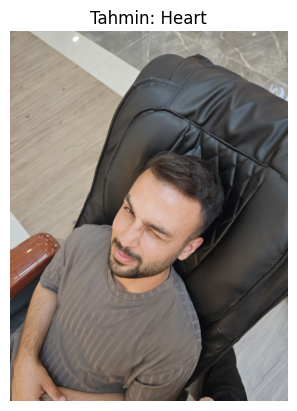

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Modeli yükle
try:
    model = load_model("en_iyi_yuz_modeli.h5")
    print("Model başarıyla yüklendi.")
except Exception as e:
    print(f"Model yüklenemedi: {e}")
    model = None

class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

def select_image():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp")]
    )
    root.destroy()
    return file_path

def preprocess_image(image_path, target_size=(160, 160)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.asarray(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def predict_image(image_path):
    try:
        img_array = preprocess_image(image_path)
        preds = model.predict(img_array)
        predicted_class = class_names[np.argmax(preds)]
        print(f"Tahmin edilen yüz şekli: {predicted_class}")

        img_show = Image.open(image_path)
        plt.imshow(img_show)
        plt.axis('off')
        plt.title(f"Tahmin: {predicted_class}")
        plt.show()

        root = tk.Tk()
        root.withdraw()
        messagebox.showinfo("Tahmin Sonucu", f"Tahmin edilen yüz şekli: {predicted_class}")
        root.destroy()
    except Exception as e:
        print(f"Tahmin sırasında hata oluştu: {e}")
        root = tk.Tk()
        root.withdraw()
        messagebox.showerror("Hata", f"Tahmin sırasında hata oluştu:\n{e}")
        root.destroy()

if model is not None:
    image_path = select_image()
    if image_path:
        predict_image(image_path)
    else:
        print("Herhangi bir fotoğraf seçilmedi.")
else:
    print("Model yüklenemediği için tahmin yapılamıyor.")